In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pbn import operations as ops
from pbn import conversions as convert
from pbn import functions as fxn
from scipy import ndimage
%matplotlib inline

(1040, 836, 3)


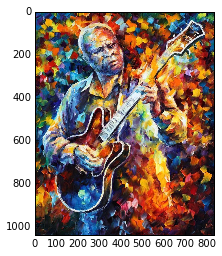

In [5]:
import matplotlib.image as matimg
import os
#img_d = matimg.imread('/Users/eczech/Downloads/google.png')
img_rgb = matimg.imread('/Users/eczech/Documents/afremov_bbking.png')
img_path = lambda filename: os.path.join('/Users/eczech/data/pbn', filename)
print(img_rgb.shape)
plt.imshow(img_rgb)

In [7]:
#img_rgb = img_rgb[:200,:400,:]

In [8]:
img_lab = convert.rgb_to_lab(img_rgb)

In [92]:
#alpha = .002 # best so far for gmm
#alpha = .006 # also good for gmm
alpha = .008
#alpha = 10
img_df = ops.unravel(img_lab)
img_df[['l', 'a', 'b']] = img_df[['l', 'a', 'b']] * alpha
img_df.head()

,x,y,l,a,b
0,0,0,0.260208,0.056485,-0.340721
1,0,1,0.459782,-0.034476,-0.331394
2,0,2,0.369438,-0.015297,-0.323553
3,0,3,0.386368,-0.027799,-0.319946
4,0,4,0.308002,0.003827,-0.317424


In [93]:
from sklearn.mixture import DPGMM, GMM
#from sklearn.cluster import MiniBatchKMeans
#mm = DPGMM(n_components=1000, alpha=.1, n_iter=50)
#mm = GMM(n_components=150)
mm = GMM(n_components=750)
#mm = MiniBatchKMeans(n_clusters=500)
mm.fit(img_df)
img_pred = mm.predict(img_df)

In [94]:
mm.converged_

True

In [95]:
len(np.unique(img_pred))

750

In [96]:
mm.means_.shape
#mm.cluster_centers_.shape

(750, 5)

In [97]:
img_all = pd.concat([img_df, pd.Series(img_pred)], axis=1)
img_all = img_all.rename(columns={0: 'c'})
img_all.index.name = 'order'
img_all.head()

,x,y,l,a,b,c
order,,,,,,
0,0,0,0.260208,0.056485,-0.340721,539
1,0,1,0.459782,-0.034476,-0.331394,539
2,0,2,0.369438,-0.015297,-0.323553,539
3,0,3,0.386368,-0.027799,-0.319946,539
4,0,4,0.308002,0.003827,-0.317424,539


In [98]:
len(img_all['c'].unique())

750

In [99]:
color_clusters = img_all.groupby('c')[['l', 'a', 'b']].mean()
color_clusters.head()

,l,a,b
c,,,
0,0.358890,-0.093913,-0.088746
1,0.741019,-0.032980,0.161733
2,0.114464,0.049433,0.052358
3,0.649305,0.033128,0.238354
4,0.297179,0.219359,0.170308


In [100]:
n_before = len(img_all)
img_merged = img_all.reset_index()\
    .merge(color_clusters.reset_index(), on='c', suffixes=['', '_m'])\
    .sort('order').set_index('order')
assert n_before == len(img_merged),\
    'Some rows were somehow lost during join: size before = {}, size after = {}'.format(n_before, len(img_merged))
assert np.all(img_merged.apply(np.isfinite).apply(np.all)), 'Merged data frame has NA values somehow'
img_merged.iloc[1000:1010]

,x,y,l,a,b,c,l_m,a_m,b_m
order,,,,,,,,,
1000,1,164,0.317813,-0.020773,-0.287391,26,0.277716,-0.067447,-0.160246
1001,1,165,0.309107,-0.013462,-0.291619,26,0.277716,-0.067447,-0.160246
1002,1,166,0.309107,-0.013462,-0.291619,26,0.277716,-0.067447,-0.160246
1003,1,167,0.311910,-0.017151,-0.287154,26,0.277716,-0.067447,-0.160246
1004,1,168,0.353125,-0.045184,-0.269547,26,0.277716,-0.067447,-0.160246
1005,1,169,0.349345,-0.052019,-0.251779,26,0.277716,-0.067447,-0.160246
1006,1,170,0.342884,-0.056970,-0.228528,26,0.277716,-0.067447,-0.160246
1007,1,171,0.348420,-0.067816,-0.200669,26,0.277716,-0.067447,-0.160246
1008,1,172,0.329048,-0.072874,-0.173091,26,0.277716,-0.067447,-0.160246


In [101]:
import imp
imp.reload(convert)
imp.reload(ops)
imp.reload(fxn)

<module 'pbn.functions' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/functions.py'>

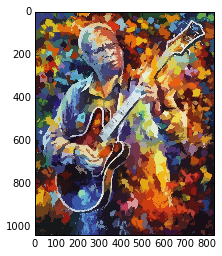

In [102]:
img_color = img_merged[[c for c in img_merged.columns if c.endswith('_m')]]
img_color = ops.reravel(img_color, *img_rgb.shape[0:2])
img_color = img_color / alpha
img_color = convert.lab_to_rgb(img_color)
#img_color = fxn.denoise_raw_img(img_color, 1)
plt.imshow(img_color)
plt.imsave('/tmp/pbn_prelim.png', img_color)

## Collapse Colors

In [103]:
avg_color_cols = [c for c in img_merged.columns if c.endswith('_m')]

In [104]:
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

def collapse_colors(flt_cluster, color_cols, n_colors=10, alpha=1):
    X = flt_cluster[color_cols] / alpha
    mm = GMM(n_components=n_colors)
    y = pd.Series(mm.fit(X).predict(X))
    assert mm.converged_, 'Mixture model did not converge'
    mean_map = dict([ (i, v * alpha) for i, v in enumerate(mm.means_) ])
    flt_cluster[['{}_c'.format(c) for c in color_cols]] = y.map(mean_map).apply(pd.Series)
    flt_cluster['cc'] = y
    return flt_cluster.sort_index(), mm


## Normalize Colors to Clusters

In [105]:
img_clustered, cmm = collapse_colors(img_merged, avg_color_cols, n_colors=24, alpha=alpha)
clustered_color_cols = [c for c in img_clustered.columns if c.endswith('_m_c')]
img_clustered.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_c,a_m_c,b_m_c,cc
order,,,,,,,,,,,,,
0,0,0,0.260208,0.056485,-0.340721,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15
1,0,1,0.459782,-0.034476,-0.331394,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15
2,0,2,0.369438,-0.015297,-0.323553,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15
3,0,3,0.386368,-0.027799,-0.319946,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15
4,0,4,0.308002,0.003827,-0.317424,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15


In [106]:
# imp.reload(palettes)

# from pbn import palettes
# palette = pd.DataFrame(palettes.rainbow_all)
# palette = palette.apply(convert._rgb_to_lab, axis=1).apply(pd.Series)
# palette *= alpha
# img_matched = fxn.match_to_palette(img_merged[avg_color_cols], palette)
# img_matched.head()

# img_clustered = img_merged.copy()
# img_clustered[['l_m_p', 'a_m_p', 'b_m_p']] = img_matched
# clustered_color_cols = [c for c in img_clustered.columns if c.endswith('_m_p')]
# img_clustered.head()

# # Show number actually matched
# img_clustered[clustered_color_cols].drop_duplicates()

### Denoise Result

In [107]:
#img_denoised = fxn.denoise_flat_img(img_clustered, img_rgb.shape, ['l_m_c', 'a_m_c', 'b_m_c'], n_iter=3)
#denoise_color_cols = [c for c in img_denoised.columns if c.endswith('_dn')]
#print(denoise_color_cols)
#img_denoised.head()

Index(['l_m_c', 'a_m_c', 'b_m_c'], dtype='object')


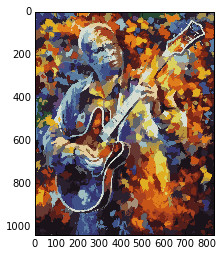

In [108]:
img_color = img_clustered[clustered_color_cols]
print(img_color.columns)
img_color = ops.reravel(img_color, *img_rgb.shape[0:2])
img_color = img_color / alpha
img_color = convert.lab_to_rgb(img_color)
#img_color = denoise_raw_img(img_color, 1)
plt.imsave('/tmp/pbn_collapsed.png', img_color)
plt.imshow(img_color)

## Show Cluster Membership

In [75]:
def get_cluster_img(flt_cluster, img_d):
    """ expecting [ c, x, y, l, a, b ] where c is cluster and l, a, and b are color means """
    colors = {}
    res = np.empty_like(img_d)
    for cluster in flt_cluster['c'].unique():
        colors[cluster] = [np.random.rand(), np.random.rand(), np.random.rand()]
    for i, r in flt_cluster[['x', 'y', 'c']].iterrows():
        res[r['x'], r['y']] = colors[r['c']]
    return res

In [495]:
img_clusters = get_cluster_img(img_clustered, img_rgb)

In [497]:
plt.imsave('/tmp/pbn_clusters_rand.png', img_clusters)

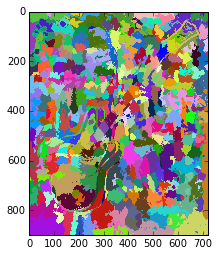

In [496]:
plt.imshow(img_clusters)

# Results

In [109]:
color_matrix = ops.reravel(img_clustered[['cc']], *img_rgb.shape[:2])
color_matrix = np.int64(np.reshape(color_matrix, img_rgb.shape[0:2]))
color_matrix.shape

(1040, 836)

In [110]:
img_clustered.head()

,x,y,l,a,b,c,l_m,a_m,b_m,l_m_c,a_m_c,b_m_c,cc
order,,,,,,,,,,,,,
0,0,0,0.260208,0.056485,-0.340721,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15
1,0,1,0.459782,-0.034476,-0.331394,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15
2,0,2,0.369438,-0.015297,-0.323553,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15
3,0,3,0.386368,-0.027799,-0.319946,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15
4,0,4,0.308002,0.003827,-0.317424,539,0.228603,0.098397,-0.30228,0.198809,0.114732,-0.27481,15


In [111]:
# Run this to make sure that the color clusters really only have one color per cluster
img_clustered.groupby('cc').apply(lambda x: len(x[['l_m_c', 'a_m_c', 'b_m_c']].drop_duplicates())).value_counts()
# This should report only "1" with a count equal to the number of clusters

1    24
dtype: int64

In [112]:
collapsed_color_clusters = img_clustered.groupby('cc')\
    .apply(lambda x: x[['l_m_c', 'a_m_c', 'b_m_c']].iloc[0])
collapsed_color_clusters.head()

,l_m_c,a_m_c,b_m_c
cc,,,
0,0.113325,0.059967,-0.058594
1,0.508801,0.057747,0.402519
2,0.490983,0.048637,0.120110
3,0.236867,0.298022,0.247892
4,0.662991,-0.059425,0.445339


In [113]:
spatial_clusters = ops.cluster_by_proximity(color_matrix, threshold=.8, shrinkage=1, n_iterations=1)

2239 clusters collapsed of 6502


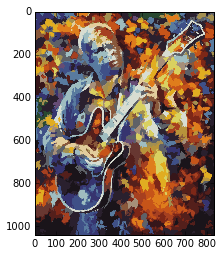

In [114]:
img_reassembled = ops.image_from_clusters(spatial_clusters, collapsed_color_clusters, img_rgb, use_random_color=False)
img_reassembled = convert.lab_to_rgb(img_reassembled / alpha)
plt.imsave('/tmp/pbn_collapsed2.png', img_reassembled)
plt.imshow(img_reassembled)

In [119]:
img_reassembled.shape

(1040, 836, 3)

In [170]:
import imp
imp.reload(ops)

<module 'pbn.operations' from '/Users/eczech/repos/portfolio/functional/paint_by_numbers/python/pbn/operations.py'>

In [146]:
cluster_props = ops.get_cluster_props(spatial_clusters, collapsed_color_clusters, color_matrix)

In [1]:
bkg = np.array(convert._rgb_to_lab([1, 1, 1.])) * alpha
edg = np.array(convert._rgb_to_lab([.5, .5, .5])) * alpha
lbl = np.array(convert._rgb_to_lab([.3, .3, .3])) * alpha
img_pbn, color_index = ops.render_pbn(cluster_props, img_rgb, bkg=bkg, edg=edg, lbl=lbl, size_limit=30, solution=True, scale_factor=2)
img_pbn = convert.lab_to_rgb(img_pbn / alpha)
matimg.imsave('/tmp/pbn_sol.png', img_pbn)
plt.imshow(img_pbn)

NameError: name 'convert' is not defined

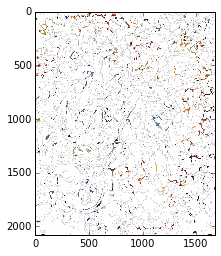

In [171]:
bkg = np.array(convert._rgb_to_lab([1, 1, 1.])) * alpha
edg = np.array(convert._rgb_to_lab([.8, .8, .8])) * alpha
lbl = np.array(convert._rgb_to_lab([.4, .4, .4])) * alpha
img_pbn_scaled, color_index = ops.render_pbn(cluster_props, img_rgb, bkg=bkg, edg=edg, lbl=lbl,
                                          size_limit=10, solution=False, scale_factor=2)
img_pbn_scaled = convert.lab_to_rgb(img_pbn_scaled / alpha)
matimg.imsave('/tmp/pbn_actual_scaled.png', img_pbn_scaled)
plt.imshow(img_pbn_scaled)

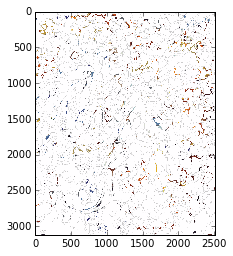

In [172]:
bkg = np.array(convert._rgb_to_lab([1, 1, 1.])) * alpha
edg = np.array(convert._rgb_to_lab([.8, .8, .8])) * alpha
lbl = np.array(convert._rgb_to_lab([.4, .4, .4])) * alpha
img_pbn_scaled, color_index = ops.render_pbn(cluster_props, img_rgb, bkg=bkg, edg=edg, lbl=lbl,
                                          size_limit=10, solution=False, scale_factor=3)
img_pbn_scaled = convert.lab_to_rgb(img_pbn_scaled / alpha)
matimg.imsave('/tmp/pbn_actual_scaled2.png', img_pbn_scaled)
plt.imshow(img_pbn_scaled)

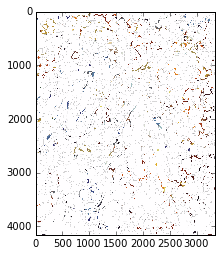

In [177]:
bkg = np.array(convert._rgb_to_lab([1, 1, 1.])) * alpha
edg = np.array(convert._rgb_to_lab([.8, .8, .8])) * alpha
lbl = np.array(convert._rgb_to_lab([.4, .4, .4])) * alpha
img_pbn_scaled, color_index = ops.render_pbn(cluster_props, img_rgb, bkg=bkg, edg=edg, lbl=lbl,
                                          size_limit=10, solution=False, scale_factor=4)
img_pbn_scaled = convert.lab_to_rgb(img_pbn_scaled / alpha)
matimg.imsave('/tmp/pbn_actual_scaled3.png', img_pbn_scaled)
plt.imshow(img_pbn_scaled)

In [178]:
img_pbn_scaled.shape

(4160, 3344, 3)

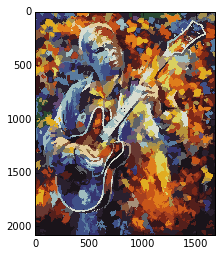

In [125]:
img_pbn_sol, color_index = ops.render_pbn(cluster_props, img_rgb, bkg=bkg, edg=edg, lbl=lbl,
                                          size_limit=10, solution=True, scale_factor=2)
img_pbn_sol = convert.lab_to_rgb(img_pbn_sol / alpha)
matimg.imsave('/tmp/pbn_sol.png', img_pbn_sol)
plt.imshow(img_pbn_sol)

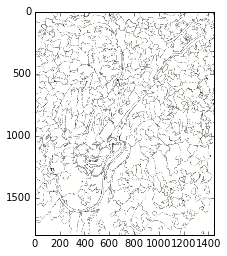

In [526]:
# from scipy import ndimage
# img_pbn_sol_blur = ndimage.gaussian_filter(img_pbn_sol, sigma=1)
# plt.imsave('/tmp/pbn_sol_blur.png', img_pbn_sol_blur)
# plt.imshow(img_pbn_sol_blur)

## Color Swatches

Save the color index in a csv file for processing via image_ml_pbn_swatch.ipynb

In [228]:
rgb_df = []
for c, l in color_index.items():
    c = convert._lab_to_rgb(np.array(c) / alpha)
    rgb_df.append((l, c[0], c[1], c[2]))
rgb_df = pd.DataFrame(rgb_df, columns=['letter', 'r', 'g', 'b'])
rgb_df.head()

,letter,r,g,b
0,C,0.167501,0.127238,0.181714
1,H,0.490522,0.152973,0.092223
2,X,0.891883,0.804097,0.613262
3,M,0.537425,0.347009,0.232841
4,O,0.776520,0.330333,0.101629


In [229]:
index_file = '/Users/eczech/repos/portfolio/demonstrative/python/notebooks/paint_by_numbers/color_index/rgb_index.csv'
rgb_df.to_csv(index_file, index=False)

##Zooming

In [505]:
x = np.empty((4,5,3))
x[:,:] = [1,2,3]
x[0:2]

array([[[ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.]],

       [[ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.],
        [ 1.,  2.,  3.]]])

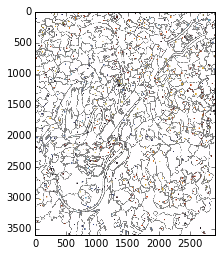

In [479]:
import scipy
img_zoom = scipy.ndimage.zoom(img_pbn, (4, 4, 1), order=1)
matimg.imsave('/tmp/pbn_zoom.png', img_zoom)
plt.imshow(img_zoom)

In [ ]:
import scipy
img_zoom = scipy.ndimage.zoom(img_pbn_sol, (4, 4, 1), order=1)
matimg.imsave('/tmp/pbn_zoom_sol.png', img_pbn_sol)
plt.imshow(img_pbn_sol)